<a href="https://colab.research.google.com/github/guylozius/Classification-of-Edible-and-Poisonous-Mushrooms/blob/main/Classification_of_Edible_and_Poisonous_Mushrooms_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.1 MB/s 
     |████████████████████████████████| 291 kB 44.1 MB/s 
     |████████████████████████████████| 965 kB 40.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from dython.nominal import associations
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.decomposition import PCA


#Mushroom Dataset

Source of data: https://www.kaggle.com/datasets/uciml/mushroom-classification

- Description: The dataset shows different feature of a list mushroom. 

- Target: Is it poisonous(class column)

- This a classification  problem

- There are  8124 rows and 23 columns.

- The dataset is from a hypothetical samples, so I do not know,<br/> if it
will be a good prediction on other dataset similar to it.



In [4]:
pd.set_option('display.max_column',None)
mushroom_df = pd.read_csv('/content/drive/MyDrive/coding dojo/stack_two/Project 2/mushrooms.csv')
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


# Cleaning Dataset

### Checking Duplicated values

In [5]:
#checking for duplicated values
mushroom_df.duplicated().sum()

0

>There no duplicted values 

## Checking for missing value

In [6]:
# Using isna() to find missing value
mushroom_df.isna().sum().any()

False

> According to isna() there are no missing values.

In [7]:
#checking all the value in each columns

for col in mushroom_df.columns:
  print(f'{col}:')
  print(mushroom_df[col].value_counts())
  print('\n\n')

class:
e    4208
p    3916
Name: class, dtype: int64



cap-shape:
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64



cap-surface:
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64



cap-color:
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64



bruises:
f    4748
t    3376
Name: bruises, dtype: int64



odor:
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64



gill-attachment:
f    7914
a     210
Name: gill-attachment, dtype: int64



gill-spacing:
c    6812
w    1312
Name: gill-spacing, dtype: int64



gill-size:
b    5612
n    2512
Name: gill-size, dtype: int64



gill-color:
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64



stalk-shape:
t    4608
e    3516
Name: stalk-sha

>The stalk-root column have value "?" I will replace with "Unknown"

In [8]:
# Replacing "?" with "Unknown"
mushroom_df.replace("?","Unknown", inplace=True)

### Changing value in column

> Changing value to full word instead of the abbreviation, so it is easier to understand.

In [9]:
#Making dict for the full words
new_word = {'class':{'e':'edible', 'p':'poisonous'},
            'cap-shape':{'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed', 's':'sunken'},
            'cap-surface':{'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'},
            'cap-color':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'bruises':{'t':'true','f':'false'},
            'odor':{'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'},
            'gill-attachment':{'a':'attached','d':'descending','f':'free','n':'notched'},
            'gill-spacing':{'c':'close','w':'crowded','d':'distant'},
            'gill-size':{'b':'broad', 'n':'narrow'},
            'gill-color':{'k':'black','n':'brown','b':'buff','h':'chocolate','g':'gray','r':'green','o':'orange','u':'purple','p':'pink','w':'white','y':'yellow'},
            'stalk-shape':{'e':'enlarging','t':'tapering'},
            'stalk-root':{'b':'bulbous','c':'club','u':'cup','e':'equal','z':'rhizomorphs','r':'rooted'},
            'stalk-surface-above-ring':{'f':'fibrous','y':'scaly','k':'siky','s':'smooth'},
            'stalk-surface-below-ring':{'f':'fibrous','y':'scaly','k':'siky','s':'smooth'},
            'stalk-color-above-ring':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'stalk-color-below-ring':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'veil-type':{'p':'partial','u':'universal'},
            'veil-color':{'n':'brown','w':'white','y':'yellow','o':'orange=o'},
            'ring-number':{'n':'none','o':'one','t':'two'},
            'ring-type':{'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','sheathing':'s','z':'zone'},
            'spore-print-color':{'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'},
            'population':{'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'},
            'habitat':{'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'}}

In [10]:
#replacing abbreviation to full words
mushroom_df.replace(new_word,inplace=True)
mushroom_df.head(10)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,true,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,true,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,true,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,true,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,false,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
5,edible,convex,scaly,yellow,true,almond,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,numerous,grasses
6,edible,bell,smooth,white,true,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,numerous,meadows
7,edible,bell,scaly,white,true,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,meadows
8,poisonous,convex,scaly,white,true,pungent,free,close,narrow,pink,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,several,grasses
9,edible,bell,smooth,yellow,true,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,meadows


# Data Exploration

In [11]:
"""A function  that plots three plots one is barplot for most frequent, and other on is barplot too  for 
   most frequent group by the class column and last boxplot of the most frequent. """
def plot_maker(col):
  fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(8,4));
  mushroom_df[col].value_counts().plot.bar( ax=ax1)
  mushroom_df.groupby(['class'])[col].value_counts().plot.bar( ax=ax2)
  ax1.set_title(f'Most frequency values in {col} column')
  ax1.tick_params(labelsize=15)
  ax2.set_title(f'Frequency values in {col} column groupby Class ')
  ax2.tick_params(labelsize=15)
  mushroom_df[col].value_counts().plot.box(ax=ax3)
  ax3.set_title(f'Most frequency values in {col} column boxplot')
  for index,data in enumerate(mushroom_df[col].value_counts()):
    ax1.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=12))
  for index,data in enumerate(mushroom_df.groupby(['class'])[col].value_counts()):
    ax2.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=12))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.7,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  plt.show()

##Distribution Plot

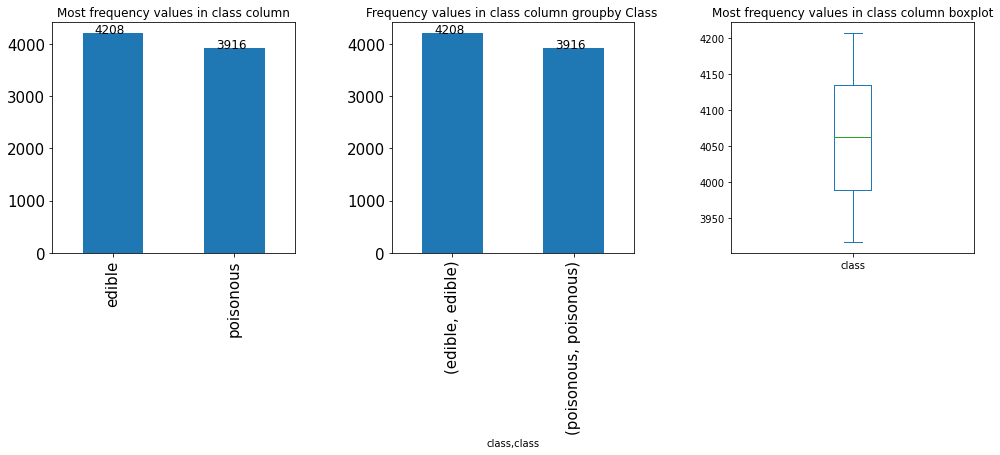

In [12]:
plot_maker('class')

> The target is balance.

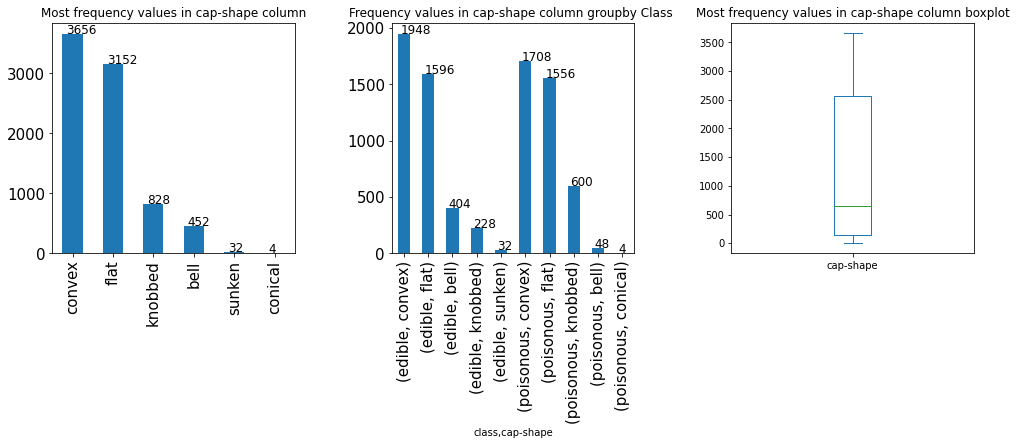

In [13]:
plot_maker('cap-shape')

> The convex is most frequency value and corical is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>



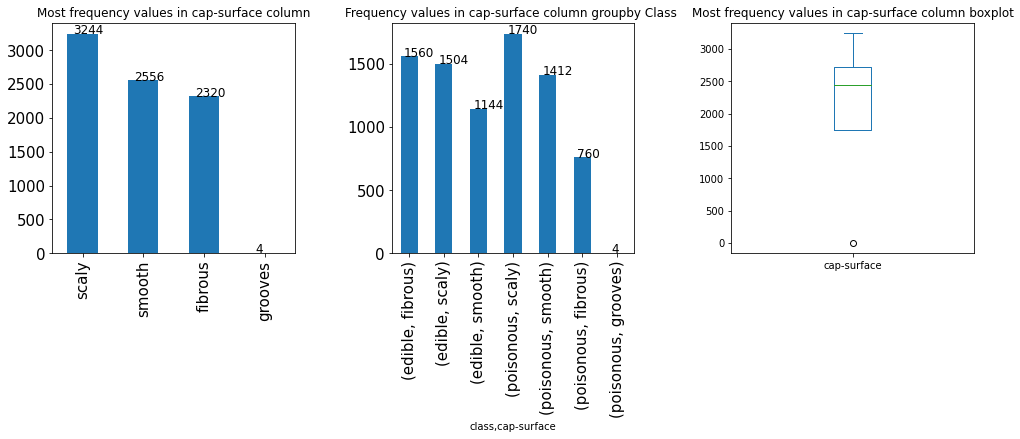

In [14]:
plot_maker('cap-surface')

>The scaly is most frequency value and grooves is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>
grooves maybe outlier.

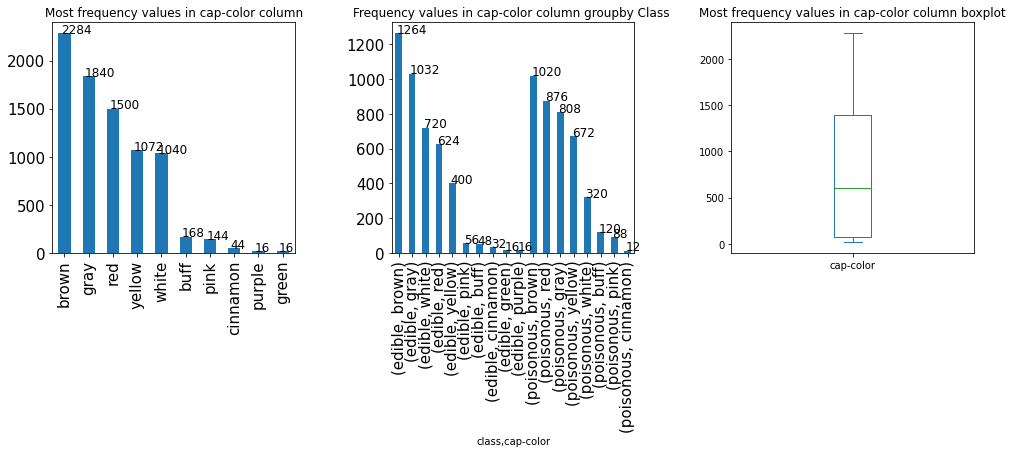

In [15]:
plot_maker('cap-color')

>The brown is most frequency value and green and pink are least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>

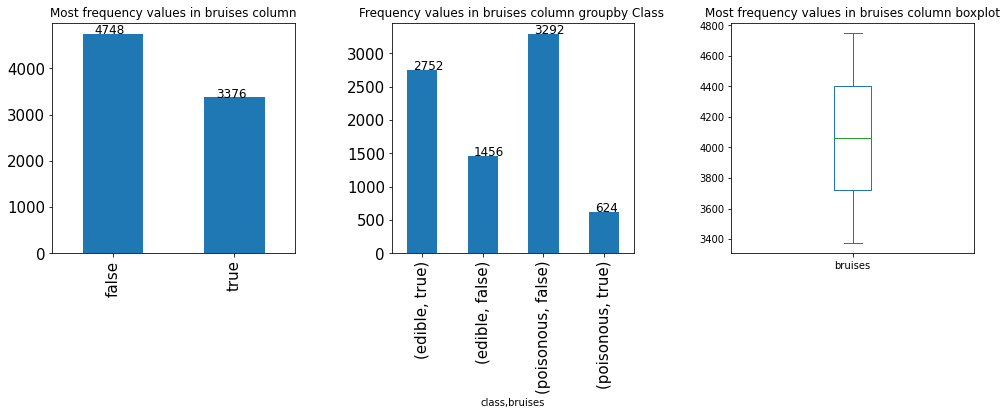

In [16]:
plot_maker('bruises')

>The No bruises is most frequency and bruises is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>

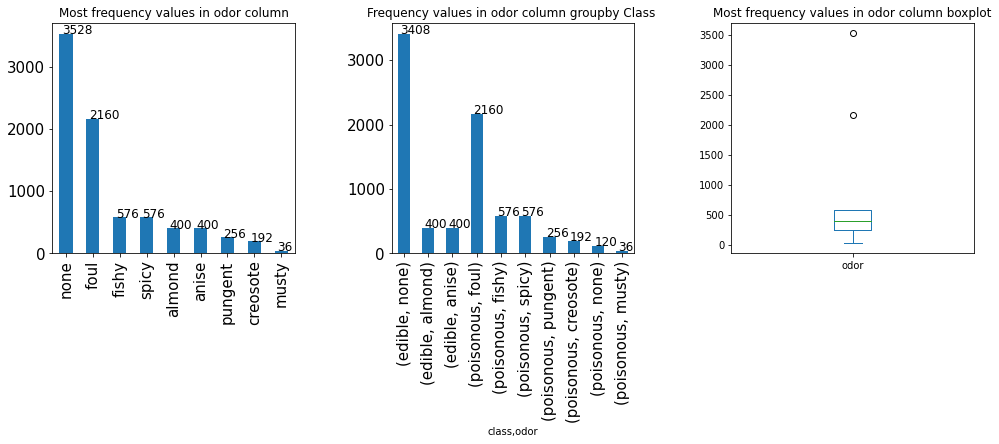

In [17]:
plot_maker('odor')

>The No smell is most frequency and musty is least frequency. <br/>
The No ,almond, and anise are edibel while the other are not.<br/>
None and foul are outliers according to boxplot.

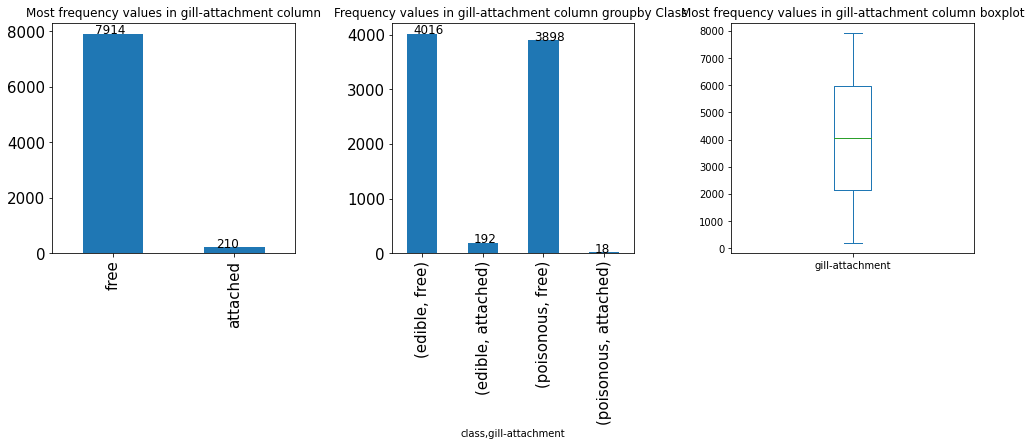

In [18]:
plot_maker('gill-attachment')

>The free gill is most frequency and attached gill is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

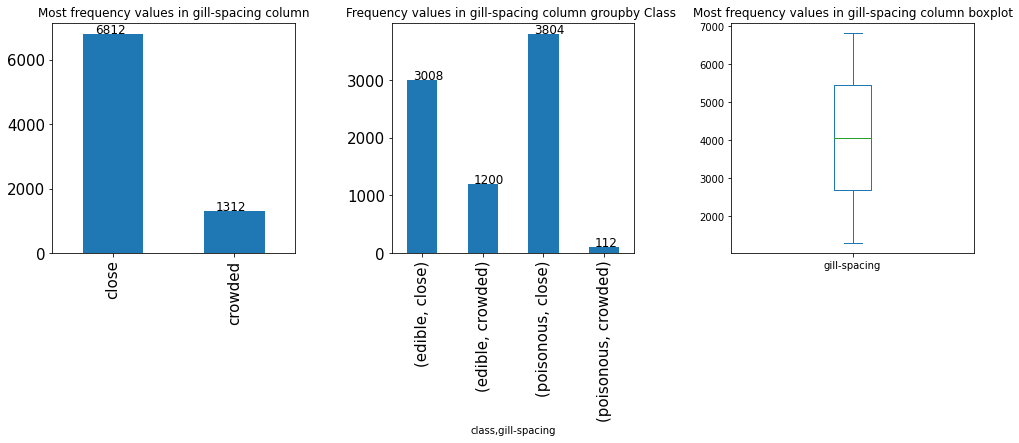

In [19]:
plot_maker('gill-spacing')

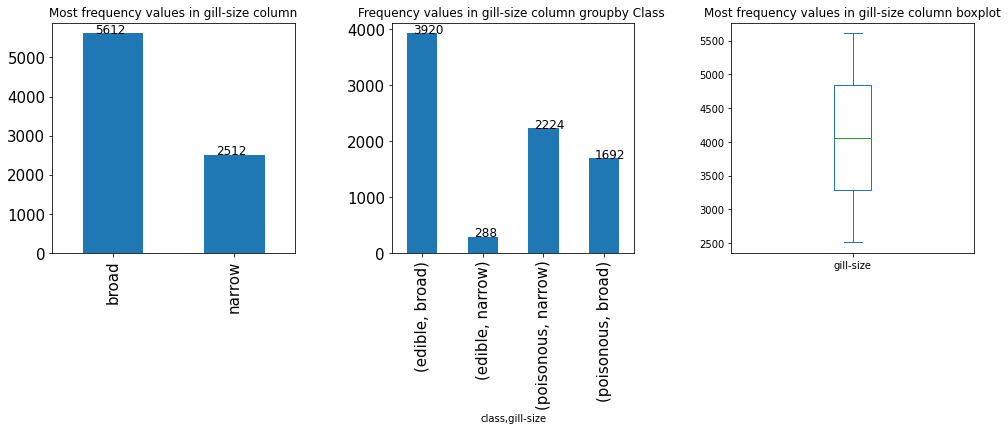

In [20]:
plot_maker('gill-size')

>The broad size gill is most frequency and narrow size gill is least frequency.<br/>
>The values are evenly distribute between edible and poisonous.

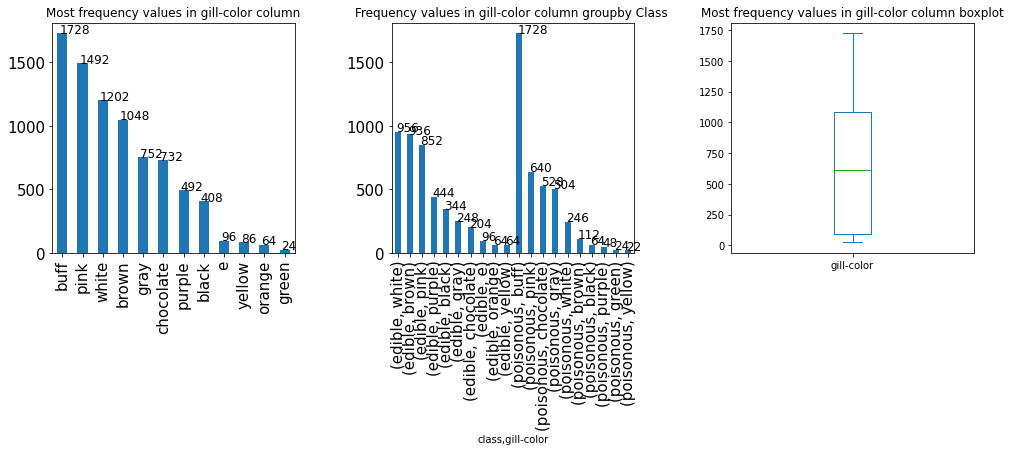

In [21]:
plot_maker('gill-color')

>The buff is most frequency and green is least frequency.<br/>
The values are evenly distribute between edible and poisonous, but all of the buff gill are poisonous.

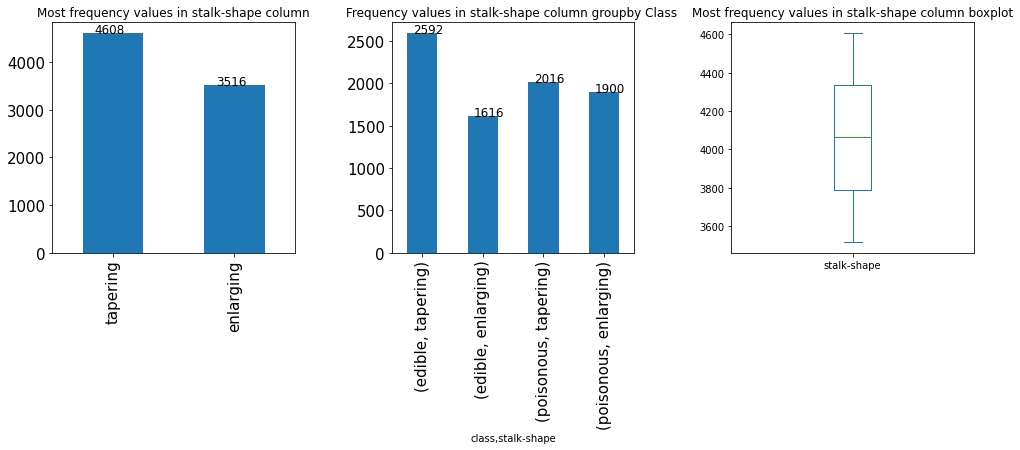

In [22]:
plot_maker('stalk-shape')

>The trapering is most frequency and enlarging is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

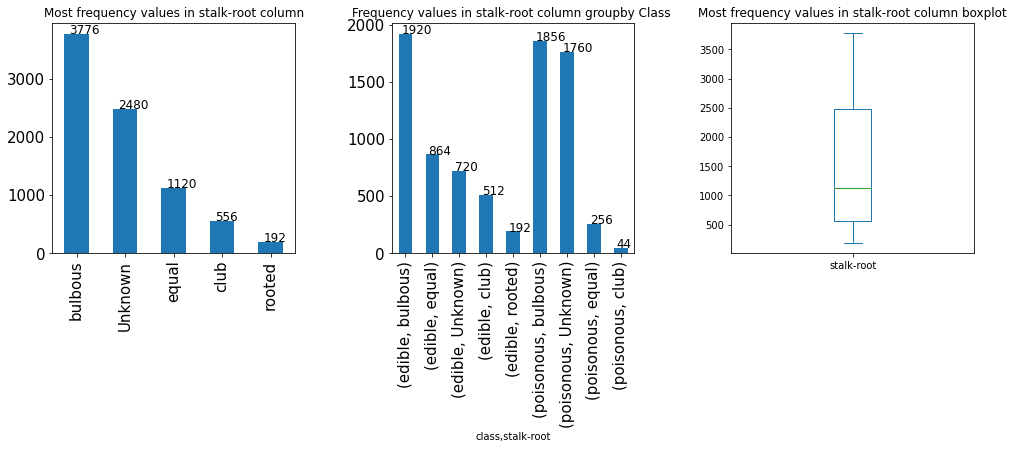

In [23]:
plot_maker('stalk-root')

>The bulbous is most frequency and rooted is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

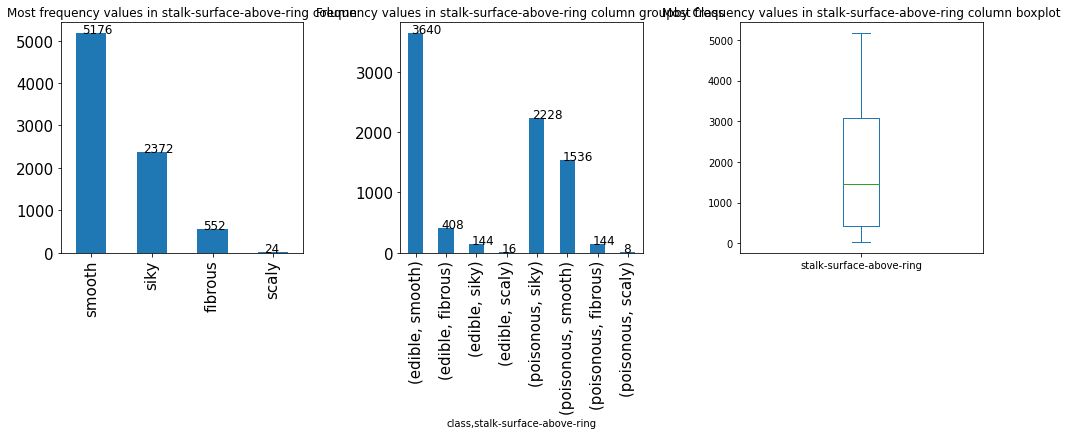

In [24]:
plot_maker('stalk-surface-above-ring')

>The smooth is most frequency and scaly is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

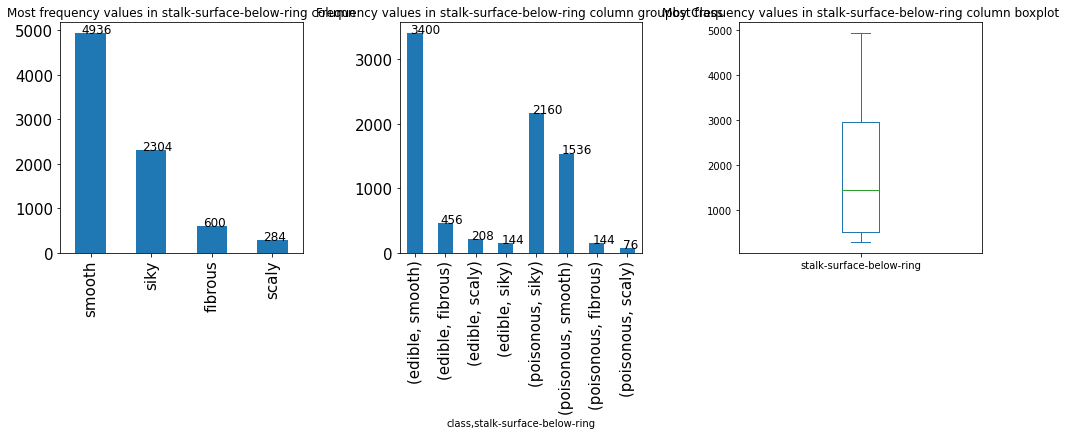

In [25]:
plot_maker('stalk-surface-below-ring')

>The smooth is most frequency and scaly is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

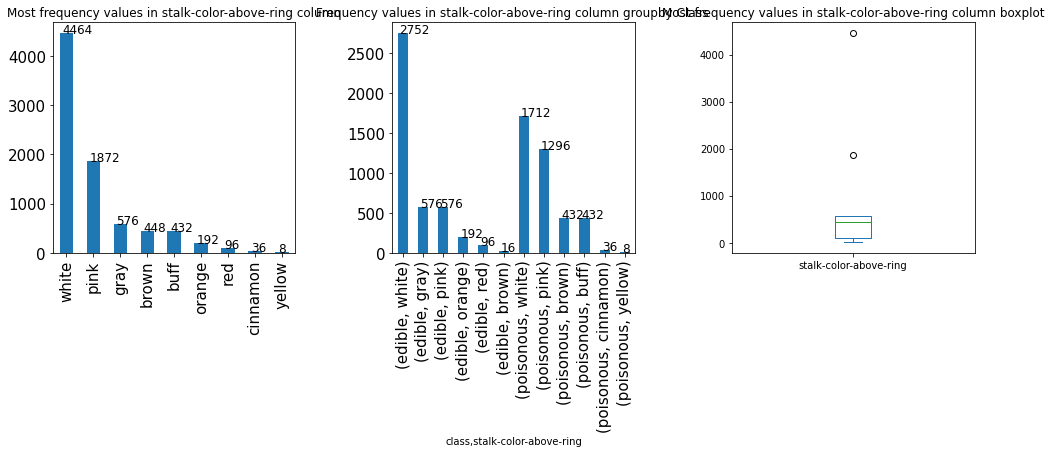

In [26]:
plot_maker('stalk-color-above-ring')

>The white is most frequency and yellow is least frequency.<br/>
The values are evenly distribute between edible and poisonous.<br/>
white and pink are outliers according to boxplot.

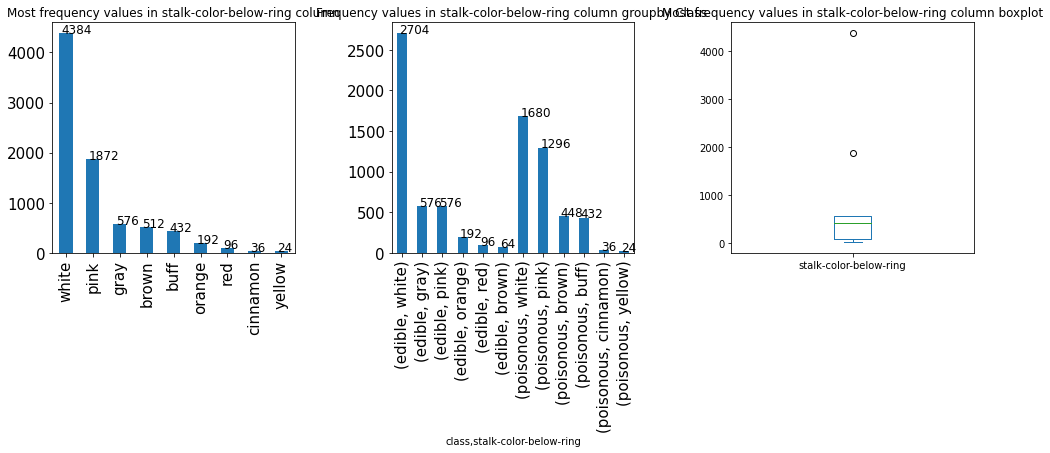

In [27]:
plot_maker('stalk-color-below-ring')

>The white is most frequency and yellow is least frequency.<br/>
The values are evenly distribute between edible and poisonous.<br/>
white and pink are outliers according to boxplot.

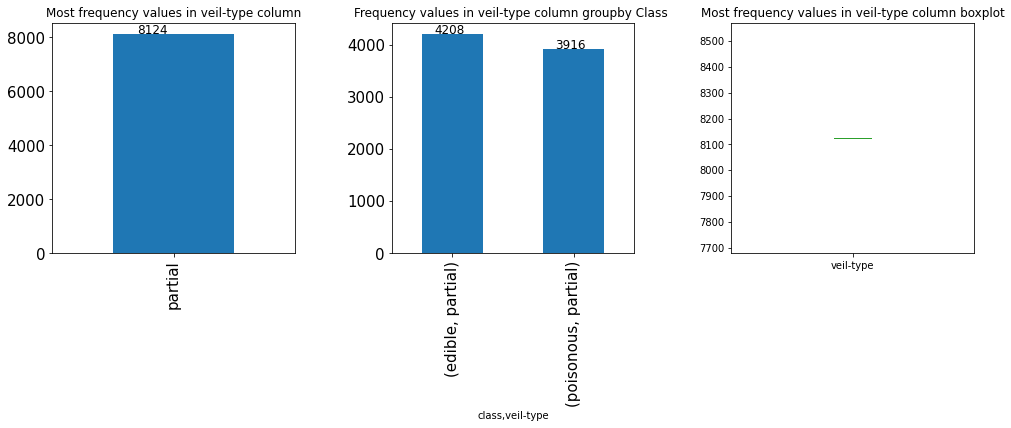

In [28]:
plot_maker('veil-type')

>Partial is only values and split evenly between edible and poisonous.
<br/>Planning on drop this column because it have one value.

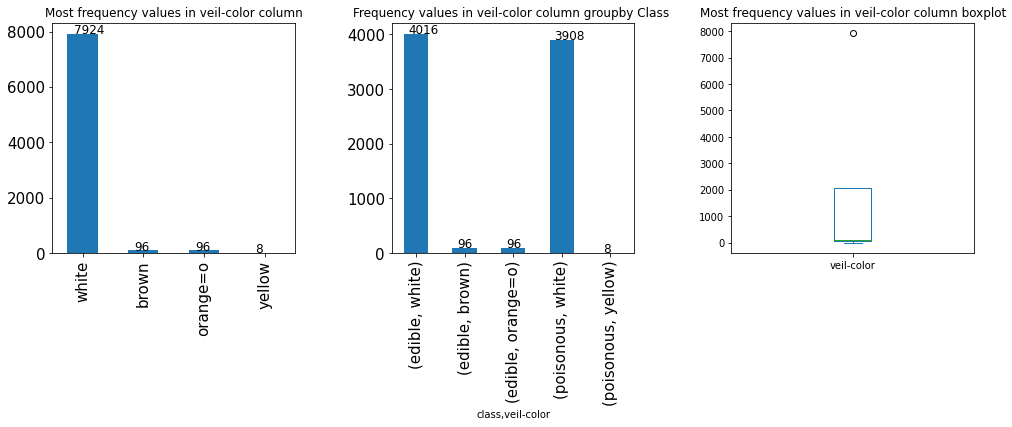

In [29]:
plot_maker('veil-color')


>The white is most frequency and yellow is least frequency.<br/>
The white is evenly distribute between edible and poisonous the other colors are not this might because of same sample size though.<br/>
White is is a outlier according to boxplot.

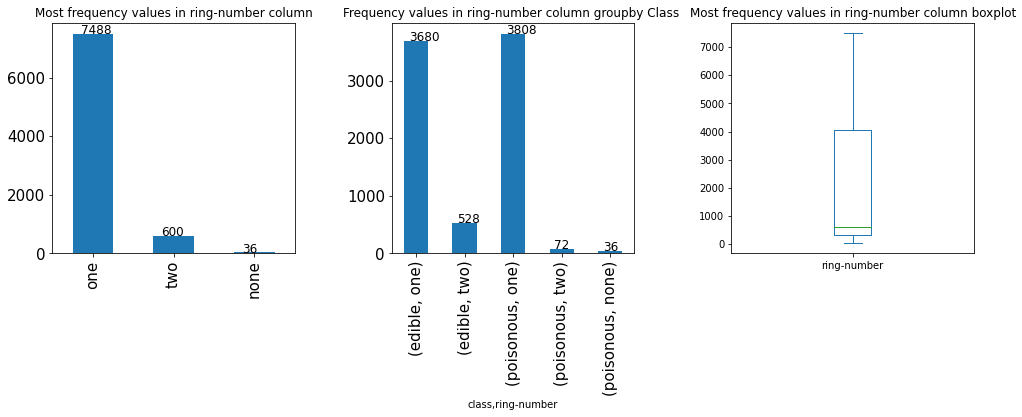

In [30]:
plot_maker('ring-number')

The one is most frequency and noneis least frequency.<br/>
The one is evenly distribute between edible and poisonous the other values are not this might because of same sample size though.

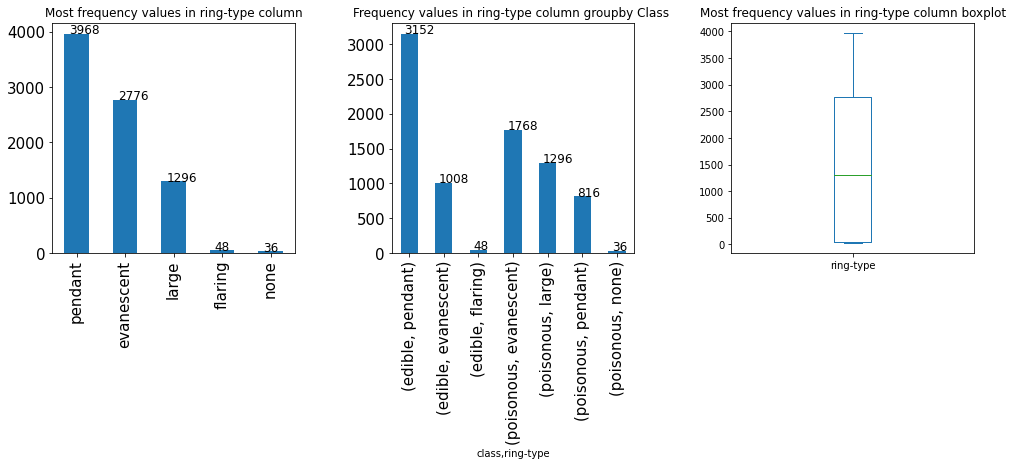

In [31]:
plot_maker('ring-type')

The peadant is most frequency and none is least frequency.<br/>
All of the pendant are poisonous.

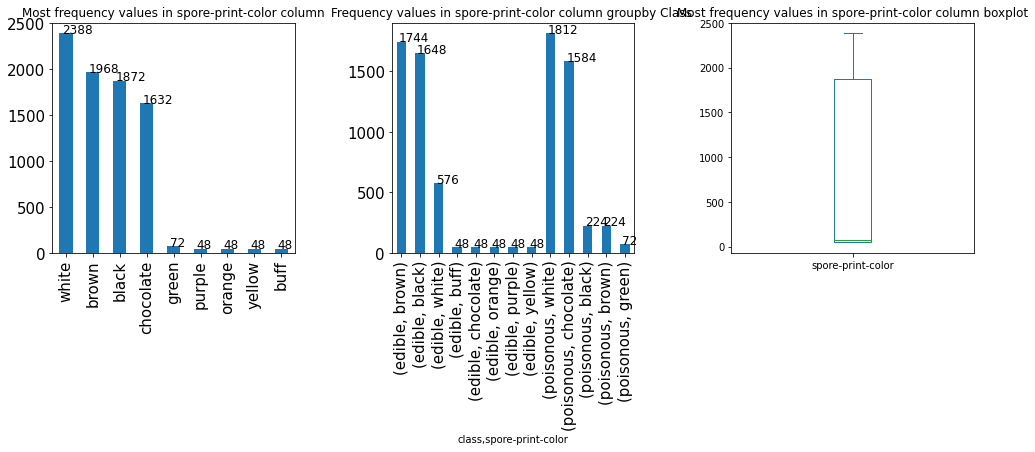

In [32]:
plot_maker('spore-print-color')

The white is most frequency and buff is least frequency.<br/>
buff, chocolate, orange, purple, yellow are edible and rest are distribute beteewn the two classes.

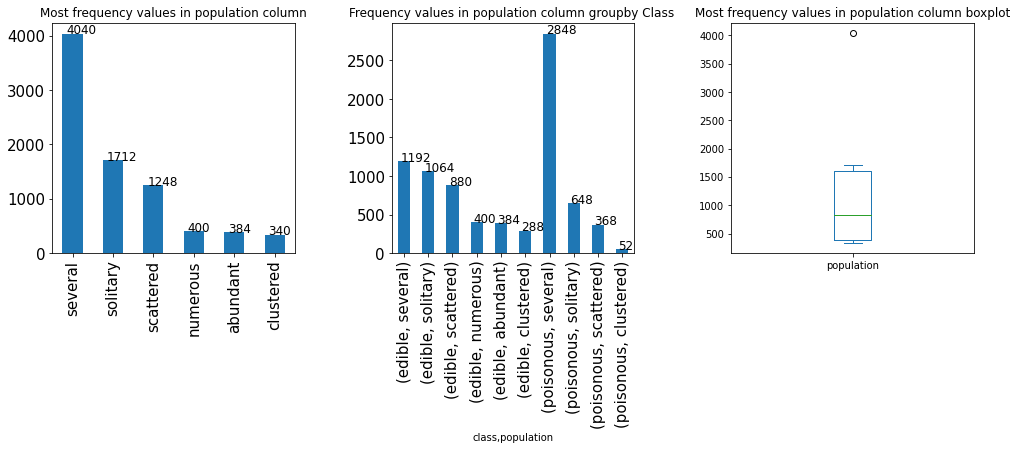

In [33]:
plot_maker('population')

The several is most frequency and clustered is least frequency.<br/>
Numerou and abundant are all edible, but rest is enve distribute beteewn the two classes.<br/>
several is a outliers according to boxplot.

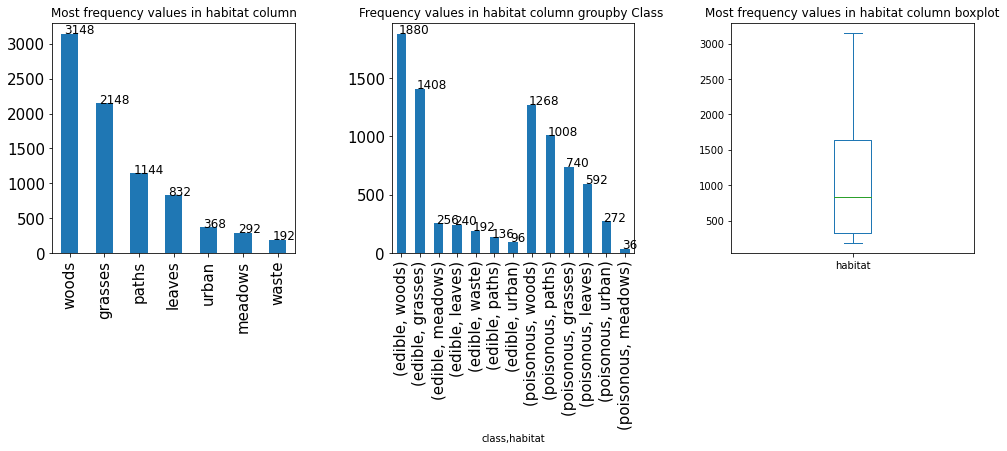

In [34]:
plot_maker('habitat')

The wood is most frequency and waste is least frequency.<br/>
meadows and waste are all edible, but rest is enve distribute beteewn the two classes.

##Correlation plot

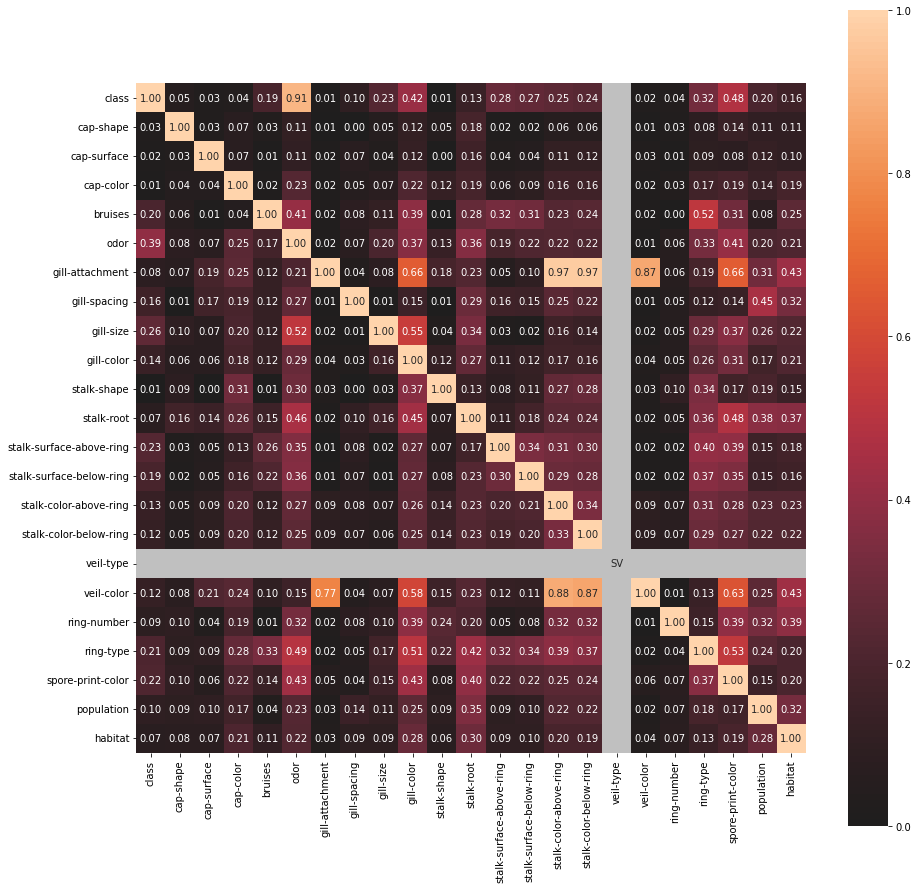

In [35]:
associations(mushroom_df,nom_nom_assoc='theil', figsize=(15, 15), plot=True, filename='/content/drive/MyDrive/coding dojo/stack_two/Project 2/corr1.png');

>For the column Class there are some moderate and strong with Odor, Gil-color, Spore-print-color columns. 

### Deeper Dive of Correlation.

In [36]:
"""This function makes heat for a given column 
   and the Class column for all their values."""
def Heatmap_maker(col):
  ohe =OneHotEncoder(sparse=False, handle_unknown='ignore')
  ohe_data = ohe.fit_transform(mushroom_df.loc[:,['class',col]])
  column_name = ohe.get_feature_names_out(mushroom_df.loc[:,['class',col]].columns)
  ohe_df = pd.DataFrame(data=ohe_data, columns = column_name)
  corr =ohe_df.corr()
  plt.figure(figsize=(15, 10))
  sns.heatmap(ohe_df.corr(), vmin=-0.5, vmax=.8, annot=True, annot_kws={'size': 10}, cmap= 'coolwarm')
  plt.tight_layout()



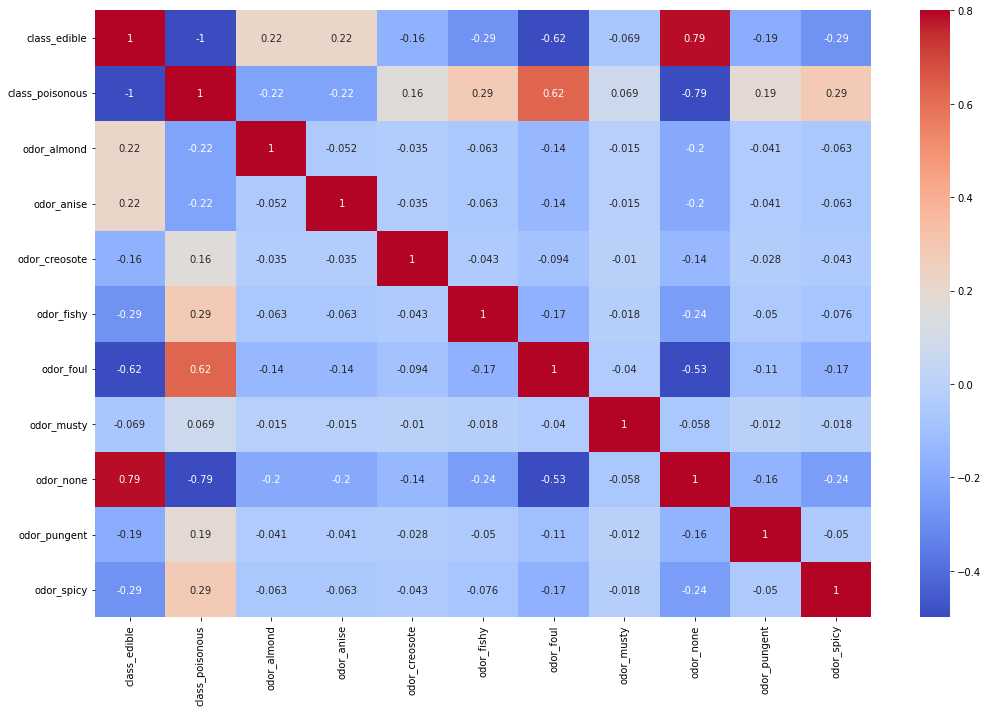

In [37]:
#Making heatmap for Odor cloumn
Heatmap_maker('odor')

> Both foul and none have strong correlation with Class Column.

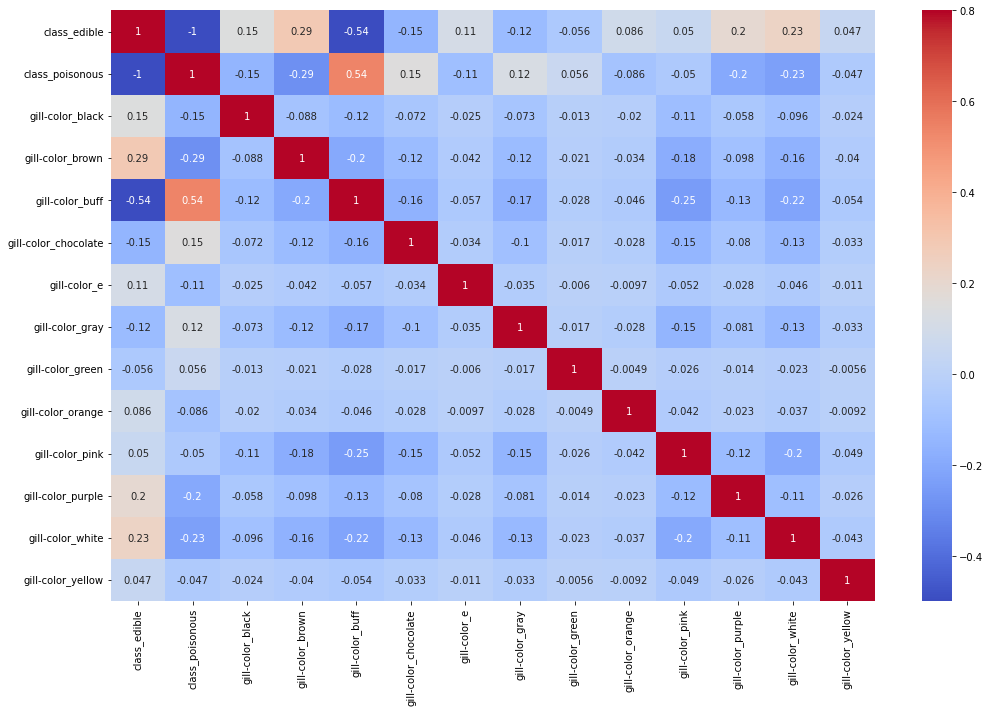

In [38]:
#Making heatmap for Gill-color cloumn
Heatmap_maker('gill-color')

> gill-color buff have moderate correlation with Class column

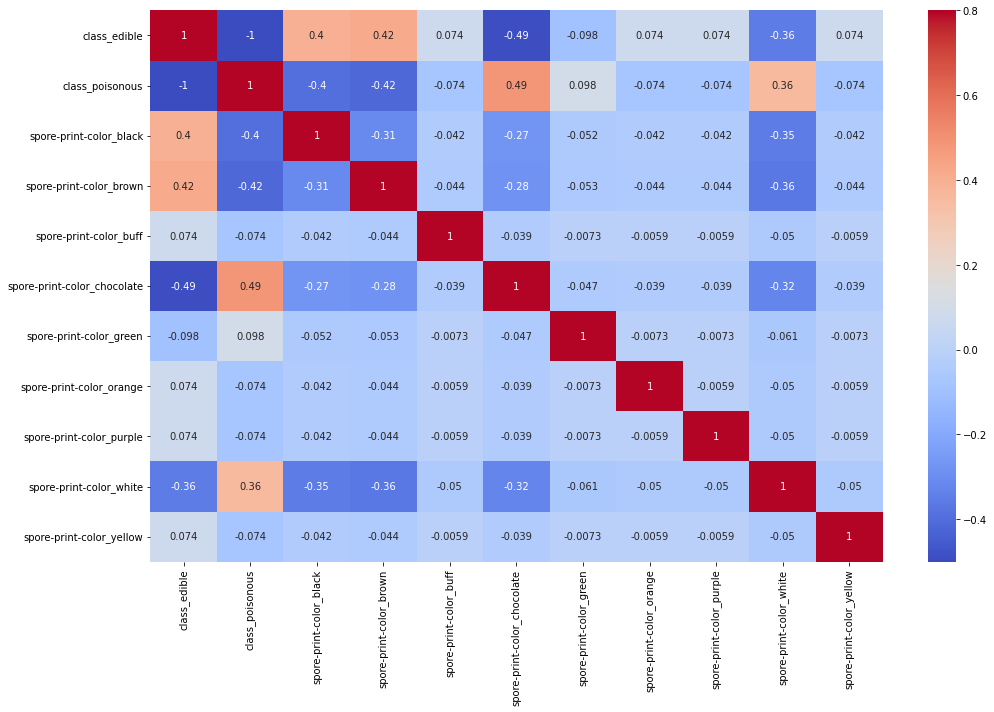

In [39]:
Heatmap_maker('spore-print-color')

> The color brown, black, chocolate have moderate correlation with the class column.

## Trends

> Which Odors are likely to be poisonous or edible.

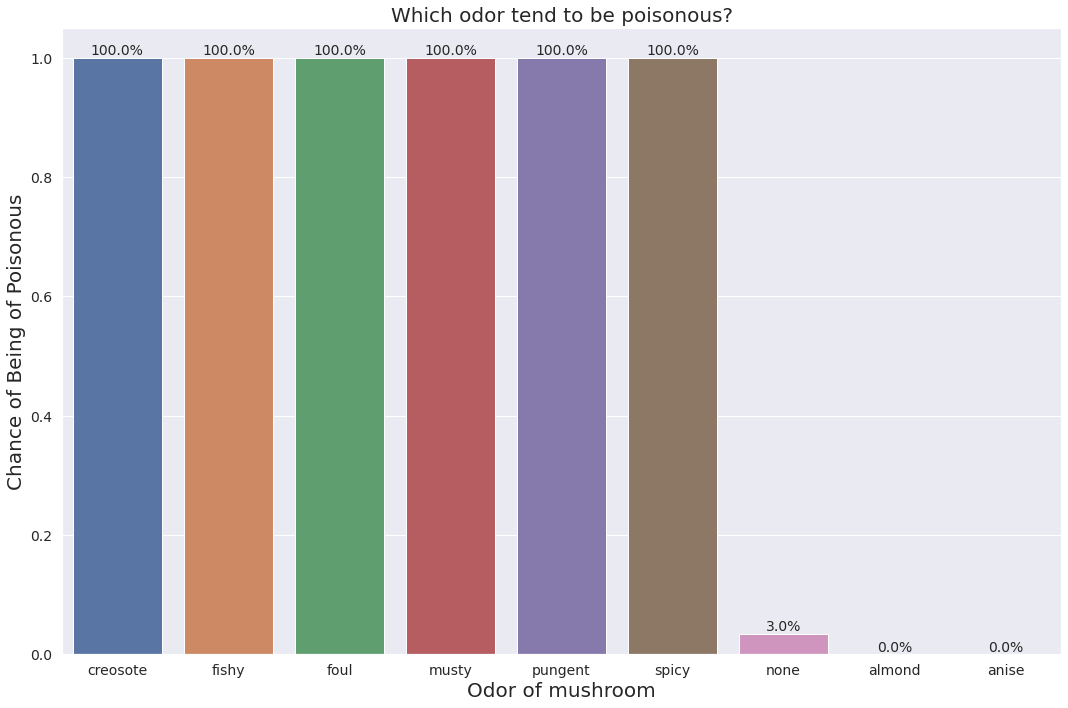

In [221]:
new_df = mushroom_df.copy()
new_df['class']= new_df['class'].replace({'edible':0,'poisonous':1})
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
# Get the percentage of class
p_class = (new_df.groupby('odor')['class'].sum()/ new_df['odor'].value_counts()).sort_values(ascending=False)
splot1 =sns.barplot(data = new_df, x = "odor",y="class",order=p_class.index, ci=None)
#add annotate
plt.bar_label(splot1.containers[0], labels=[f"{x}%" for x in (p_class * 100).round()], fontsize=14,)
plt.title('Which odor tend to be poisonous?', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Odor of mushroom', fontsize=20)
plt.ylabel('Chance of Being of Poisonous', fontsize=20)
plt.tight_layout()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/coding dojo/stack_two/Project 2/class_odor.png')

>Bad and spicy smelling mushroom tend to be poisonous.

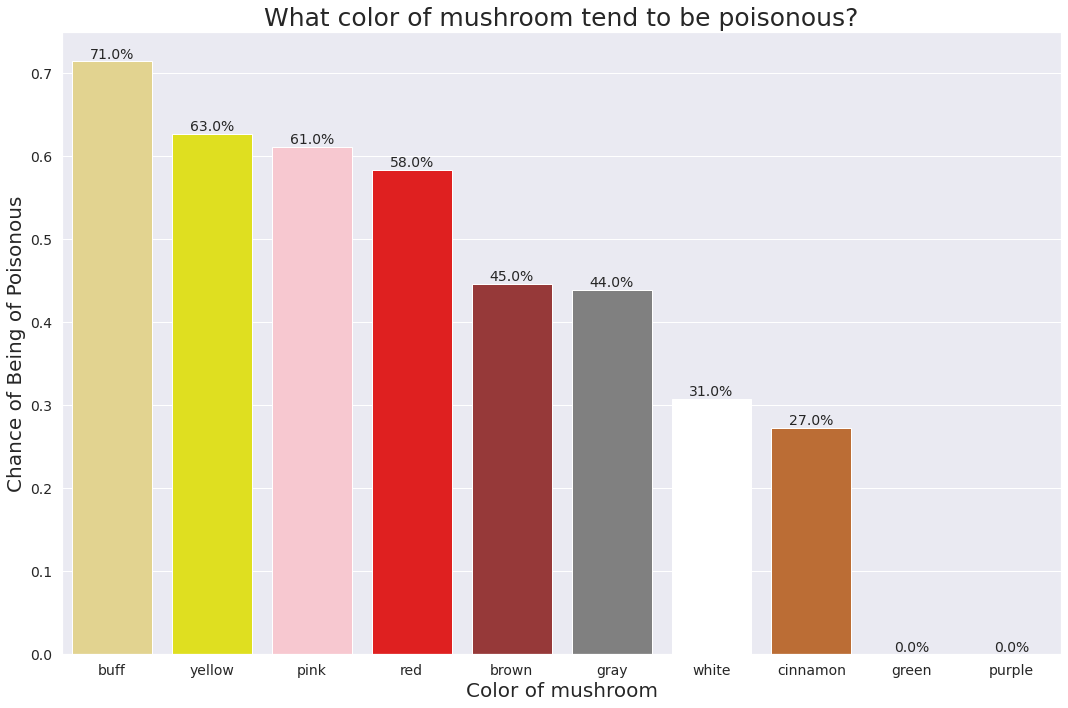

In [223]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
#creating color palette
palette = sns.color_palette(['#f0dc82','#ffff00','#ffc0cb','#ff0000','#a52a2a','#808080','#ffffff','#D2691E','#008000','#800080'])
# Get the percentage of class
p_class = (new_df.groupby('cap-color')['class'].sum()/ new_df['cap-color'].value_counts()).sort_values(ascending=False)
#Making plot
splot=sns.barplot(data = new_df, x = "cap-color",y="class", order=p_class.index, palette = palette, ci=None)
#add annotate
plt.bar_label(splot.containers[0], labels=[f"{x}%" for x in (p_class * 100).round()], fontsize=14)
plt.title('What color of mushroom tend to be poisonous?', fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Color of mushroom', fontsize=20)
plt.ylabel('Chance of Being of Poisonous', fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/coding dojo/stack_two/Project 2/color.png')

> Buff, yellow, pink, and red have a higher chance of being Poisonous.

# Creating the model 

## Spilt Data

In [42]:
X = mushroom_df.drop(columns=['class','veil-type'])
y = mushroom_df['class']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

##Preprocess 

In [43]:
# Making a one hot encode object
ohe_e = OneHotEncoder(sparse=False, handle_unknown='ignore')
#Making my Models
log = LogisticRegression()
rf = RandomForestClassifier(random_state=42,n_estimators=100)
gb = GradientBoostingClassifier()
#Putting them in a pipeline
log_pip = make_pipeline(ohe_e,log)
rf_pip = make_pipeline(ohe_e,rf)
gb_pip = make_pipeline(ohe_e,gb)


##Baseline Evaluation 

In [44]:
"""This function evaluate classification model by using classification_report
   ConfusionMatrixDisplay, and RocCurveDisplay.
 """
def evaluate_classiffication(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get Predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    scores = cross_val_score(model, X_train, y_train, cv=5)

    print(f'Accuracy scores for each fold are: {scores.round(2)}')
    print(f'Average accuracy across folds is {np.mean(scores)}')
    plt.show()

### LogisticRegression Evaluation 

In [45]:
log_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('logisticregression', LogisticRegression())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 0.9998357963875206


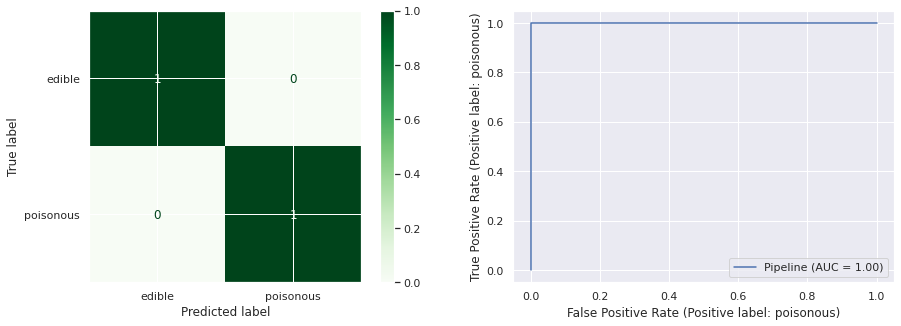

CPU times: user 2.17 s, sys: 1.15 s, total: 3.32 s
Wall time: 2.75 s


In [46]:
%%time
evaluate_classiffication(log_pip,X_test,y_test)

>Accuracy is 100%<br/>
Time is 2.75s

### RandomForestClassifier Evaluation 

In [47]:
rf_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 1.0


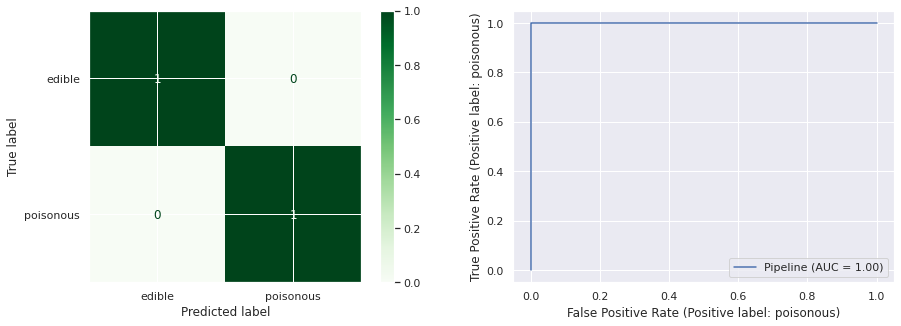

CPU times: user 2.62 s, sys: 121 ms, total: 2.74 s
Wall time: 2.64 s


In [48]:
%%time
evaluate_classiffication(rf_pip,X_test,y_test)

>Accuracy is 100%<br/>
Time is 2.64s

### GradientBoostingClassifier Evaluation

In [49]:
gb_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 1.0


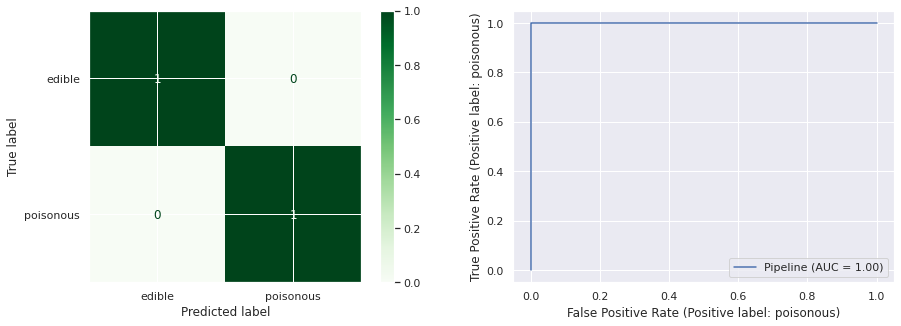

CPU times: user 6.68 s, sys: 67.6 ms, total: 6.75 s
Wall time: 6.66 s


In [50]:
%%time
evaluate_classiffication(gb_pip,X_test,y_test)

>Accuracy is 100%<br/>
Time is 6.49s

### Explanation

All the models have baseline accuracy of 100% because the dataset is made with synthetic mushroom base on average, which can lead to data leakage causing all models to have high accuracy. Now I will try to increase the speed, so it can decrease accuracy, then tune the model to increase accuracy, and by doing this I hope to make the best that I can with this data set. 

## Increasing Model Speed with PCA

### Choosing the Number of Components to Return

In [51]:
# Fit & transform data.
scale_df = ohe_e.fit_transform(X)
#Fit data with PCA
pca = PCA()
pca.fit(scale_df)

PCA()

In [52]:
len(pca.explained_variance_ratio_.cumsum())

116

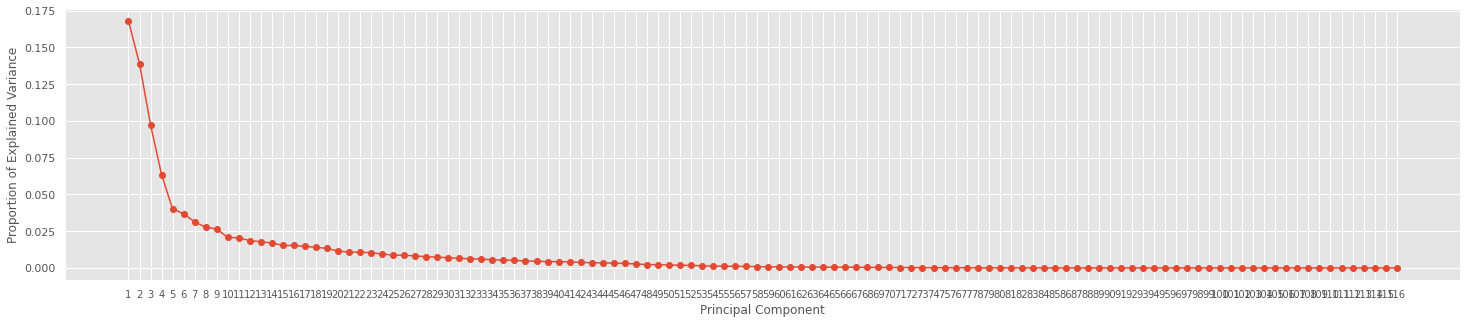

In [53]:
plt.style.use("ggplot") 
plt.figure(figsize=(25,5))
plt.plot(range(1, 117), pca.explained_variance_ratio_, marker = 'o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')
plt.xticks(ticks=range(1,117), fontsize=10);

>Using the elbow method I will pick 5 principal components. 

### Making new pipeline

In [54]:
# PCA with 5 components
pca5 = PCA(n_components=5)
# Making pipeline
log_pca_pip = make_pipeline(ohe_e,pca5,log)
rf_pca_pip = make_pipeline(ohe_e,pca5,rf)
gb_pca_pip = make_pipeline(ohe_e,pca5,gb)

### Fit all models to train set

In [55]:
log_pca_pip.fit(X_train,y_train)
rf_pca_pip.fit(X_train,y_train)
gb_pca_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('pca', PCA(n_components=5)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

### LogisticRegression Evaluation 

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       0.93      0.96      0.95      1040
   poisonous       0.96      0.93      0.94       991

    accuracy                           0.94      2031
   macro avg       0.94      0.94      0.94      2031
weighted avg       0.94      0.94      0.94      2031

Accuracy scores for each fold are: [0.95 0.95 0.96 0.95 0.94]
Average accuracy across folds is 0.9492843874558676


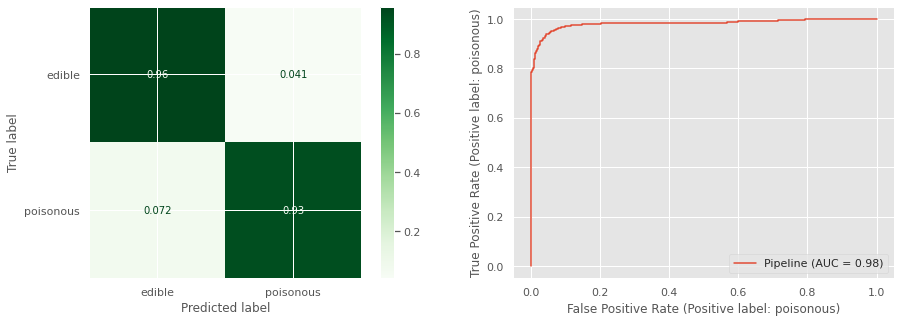

CPU times: user 1.53 s, sys: 937 ms, total: 2.47 s
Wall time: 1.45 s


In [56]:
%%time
evaluate_classiffication(log_pca_pip,X_test,y_test)

With pac:
<ul>
  <li>Accuracy:  94%</li>
  <li>Time:  1.45s</li>
</ul>
Without pac:
<ul>
  <li>Accuracy is 100%</li>
  <li>Time is 2.75s</li>
</ul>

>This model had a impove on time but a decrease of accuracy.

### RandomForestClassifier Evaluation 

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 0.9995077932731746


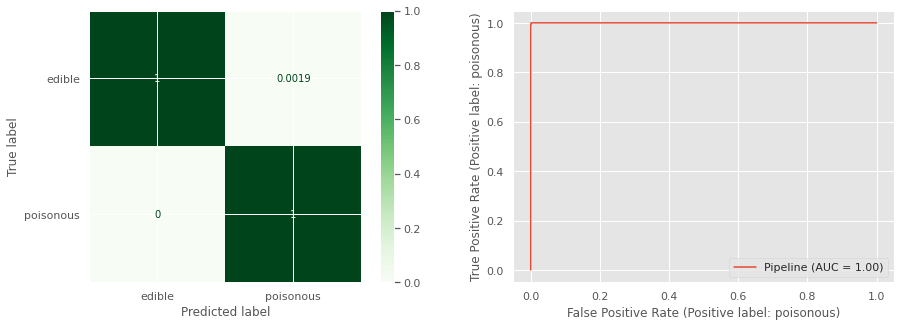

CPU times: user 5.06 s, sys: 1.4 s, total: 6.46 s
Wall time: 4.9 s


In [57]:
%%time
evaluate_classiffication(rf_pca_pip,X_test,y_test)

><br/>

With pac:
<ul>
  <li>Accuracy: 100%</li>
  <li>Time: 4.9s</li>
</ul>
Without pac:
<ul>
  <li>Accuracy: 100%</li>
  <li>Time: 2.64s</li>
</ul>

This model had a impove on time but a stay at the same accuracy.

### GradientBoostingClassifier Evaluation

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      0.99      0.99      1040
   poisonous       0.99      1.00      0.99       991

    accuracy                           0.99      2031
   macro avg       0.99      0.99      0.99      2031
weighted avg       0.99      0.99      0.99      2031

Accuracy scores for each fold are: [1.   1.   0.99 1.   0.99]
Average accuracy across folds is 0.9955683883125822


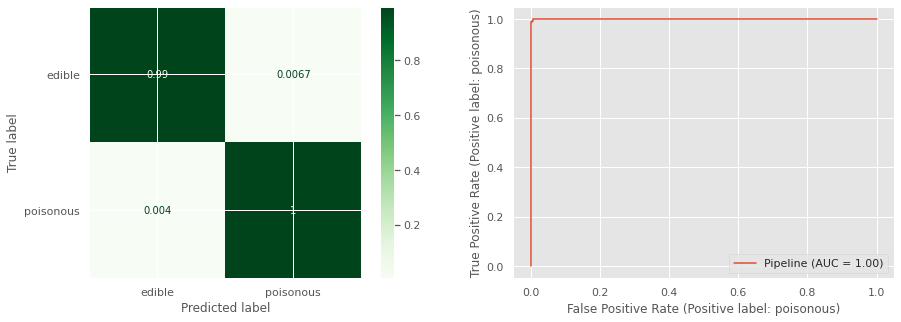

CPU times: user 6.55 s, sys: 1.18 s, total: 7.73 s
Wall time: 6.34 s


In [58]:
%%time
evaluate_classiffication(gb_pca_pip,X_test,y_test)

>
With pac:
<ul>
  <li>Accuracy: 99%
</li>
  <li>Time: 6.3s</li>
</ul>
Without pac:
<ul>
  <li>Accuracy: 100%</li>
  <li>Time: 6.66s</li>
</ul>

This model had a impove on time but a decrease of accuracy.

### Tune PCA models

> I will only tune the model with an accuracy less than 100%.

#### optimize

In [59]:
# The params that will be config 
gb_params = {
 'gradientboostingclassifier__max_depth': range(3,10),
 'gradientboostingclassifier__n_estimators': [1,10,100,1000],
 'gradientboostingclassifier__min_samples_split': [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
 }
log_params= {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
             'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet']}
# making GridSearchCV model
gb_cv = GridSearchCV(gb_pca_pip, gb_params)
log_cv = GridSearchCV(log_pca_pip, log_params)
#Fit the model on X_train
gb_cv.fit(X_train, y_train)
log_cv.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1400 fits failed out of a total of 1540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble

GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore',
                                                      sparse=False)),
                                       ('pca', PCA(n_components=5)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
                         'logisticregression__penalty': ['none', 'l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'sag',
                                                        'saga']})

#### Setup the optimize GradientBoostingClassifier

In [60]:
#Getting the best params
gb_cv.best_estimator_

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('pca', PCA(n_components=5)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, min_samples_split=1.0,
                                            n_estimators=1000))])

>- max_depth=5 
- min_samples_split=1.0
-n_estimators=1000

In [61]:
#Making new gb and pac pipline then fit it on Train set
new_gb = GradientBoostingClassifier(max_depth=5, min_samples_split=1.0, n_estimators=1000)
new_gb_pip = make_pipeline(ohe_e, pca, new_gb)
new_gb_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, min_samples_split=1.0,
                                            n_estimators=1000))])

####Setup the optimize LogisticRegression 

In [62]:
#Getting the best params 
log_cv.best_estimator_

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('pca', PCA(n_components=5)),
                ('logisticregression', LogisticRegression(C=100))])

>- C=100 
- penalty='l1', 
- solver='liblinear'

In [63]:
#Making new log and pac pipline then fit it on Train set
new_log = LogisticRegression(C=100, penalty='l1', solver='liblinear')
new_log_pip = make_pipeline(ohe_e, pca, new_log)
new_log_pip.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('pca', PCA()),
                ('logisticregression',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

>

> 

### Evaluation of optimize models

#####Optimize GradientBoostingClassifier

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 0.9996718621821165


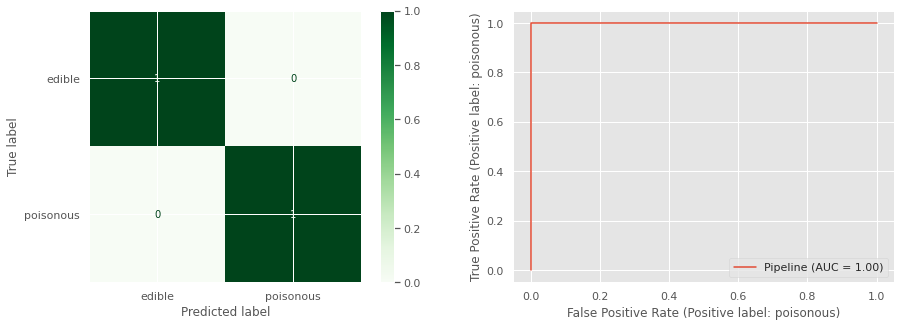

CPU times: user 5min 26s, sys: 1.29 s, total: 5min 28s
Wall time: 5min 25s


In [64]:
%%time
evaluate_classiffication(new_gb_pip,X_test,y_test)

#### Optimize LogisticRegression

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1040
   poisonous       1.00      1.00      1.00       991

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

Accuracy scores for each fold are: [1. 1. 1. 1. 1.]
Average accuracy across folds is 1.0


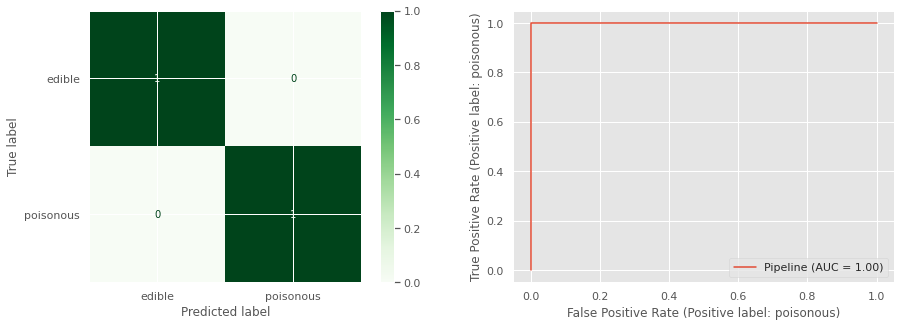

CPU times: user 2.25 s, sys: 1.07 s, total: 3.32 s
Wall time: 1.92 s


In [65]:
%%time
evaluate_classiffication(new_log_pip,X_test,y_test)

# The model I pick for "production" 

>The model I picked for "production" is  LogisticRegression for classification of poisonous and edible mushrooms because it is fastest and with high accuracy, but the dataset is made with synthetic mushroom base on average, so I do not know how it will fare against real mushrooms.
